In [1]:
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_log_error
import io

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px


In [2]:
oil_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/oil.csv')
stores_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/stores.csv')
holidays_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/holidays_events.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
stores_geo = stores_data.groupby(['state','city'])[['type']].count()
stores_geo

type
state                          city               
Azuay                          Cuenca            3
Bolivar                        Guaranda          1
Chimborazo                     Riobamba          1
Cotopaxi                       Latacunga         2
El Oro                         Machala           2
Esmeraldas                     Esmeraldas        1
Guayas                         Daule             1
                               Guayaquil         8
                               Libertad          1
                               Playas            1
Imbabura                       Ibarra            1
Loja                           Loja              1
Los Rios                       Babahoyo          1
                               Quevedo           1
Manabi                         El Carmen         1
                               Manta             2
Pastaza                        Puyo              1
Pichincha                      Cayambe           1
                               Quito            18
Santa Elena                    Salinas           1
Santo Domingo de los Tsachilas Santo Domingo     3
Tungurahua                     Ambato            2

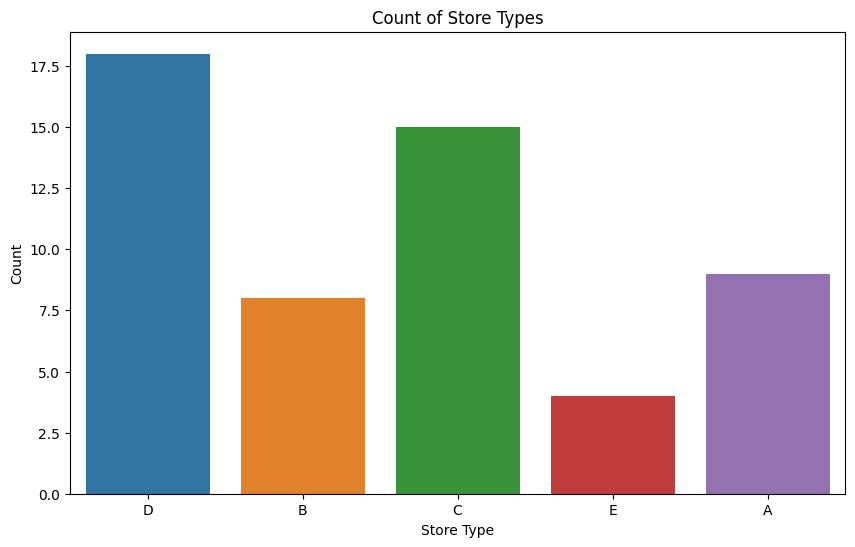

In [6]:
# Visualize store types
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=stores_data)
plt.title('Count of Store Types')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()

In [7]:
train_data_copy = train_data.copy()

In [8]:
'''unique_years = train_data_copy.index.year.unique()
print(unique_years)'''

'unique_years = train_data_copy.index.year.unique()\nprint(unique_years)'

In [9]:
'''for each_year in [2013, 2014, 2015, 2016, 2017]:
    # Filter data for the year 2013
    data_for_each_year = train_data_copy[train_data_copy.index.year == each_year]
    weekly_sales_each_year = data_for_each_year.resample('W').sum()

    additional_data = weekly_sales_each_year['sales']

    # Calculate statistical measures
    year_statistics_measures = weekly_sales_each_year.describe()
    print(year_statistics_measures)

    # Plot the weekly data for the year 2013 as bars
    plt.figure(figsize=(10, 6))
    plt.bar(weekly_sales_each_year.index, weekly_sales_each_year['sales'], label=f'Sales - {each_year}', width=5, alpha=0.7)

    # Overlay additional data as a line
    plt.plot(weekly_sales_each_year.index, additional_data, label='Additional Data', color='red', linestyle='dashed', linewidth=2)

    plt.title(f'Stores Sales Data - Weekly {each_year}')
    plt.xlabel('Date')
    plt.ylabel('Sales (units)')
    plt.legend()  # Add legend to distinguish between bars and lines
    plt.grid(True)
    plt.show()
'''

"for each_year in [2013, 2014, 2015, 2016, 2017]:\n    # Filter data for the year 2013\n    data_for_each_year = train_data_copy[train_data_copy.index.year == each_year]\n    weekly_sales_each_year = data_for_each_year.resample('W').sum()\n\n    additional_data = weekly_sales_each_year['sales']\n\n    # Calculate statistical measures\n    year_statistics_measures = weekly_sales_each_year.describe()\n    print(year_statistics_measures)\n\n    # Plot the weekly data for the year 2013 as bars\n    plt.figure(figsize=(10, 6))\n    plt.bar(weekly_sales_each_year.index, weekly_sales_each_year['sales'], label=f'Sales - {each_year}', width=5, alpha=0.7)\n\n    # Overlay additional data as a line\n    plt.plot(weekly_sales_each_year.index, additional_data, label='Additional Data', color='red', linestyle='dashed', linewidth=2)\n\n    plt.title(f'Stores Sales Data - Weekly {each_year}')\n    plt.xlabel('Date')\n    plt.ylabel('Sales (units)')\n    plt.legend()  # Add legend to distinguish between

In [10]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
print(f'train {train_data.shape}')
print(f'test {test_data.shape}')
print(f'stores {stores_data.shape}')
print(f'oil {oil_data.shape}')
print(f'holidays {holidays_data.shape}')

train (3000888, 6)
test (28512, 5)
stores (54, 5)
oil (1218, 2)
holidays (350, 6)


In [12]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


In [13]:
train_data= train_data.set_index(train_data['date'])
train_data.index.names = ['date_time']
train_data.index = pd.to_datetime(train_data.index)

In [14]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
date_time,,,,,,
2013-01-01,0,2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,2013-01-01,1,BABY CARE,0.0,0
2013-01-01,2,2013-01-01,1,BEAUTY,0.0,0
2013-01-01,3,2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,4,2013-01-01,1,BOOKS,0.0,0


In [15]:
train_data.groupby(['family']).size()

family
AUTOMOTIVE                    90936
BABY CARE                     90936
BEAUTY                        90936
BEVERAGES                     90936
BOOKS                         90936
BREAD/BAKERY                  90936
CELEBRATION                   90936
CLEANING                      90936
DAIRY                         90936
DELI                          90936
EGGS                          90936
FROZEN FOODS                  90936
GROCERY I                     90936
GROCERY II                    90936
HARDWARE                      90936
HOME AND KITCHEN I            90936
HOME AND KITCHEN II           90936
HOME APPLIANCES               90936
HOME CARE                     90936
LADIESWEAR                    90936
LAWN AND GARDEN               90936
LINGERIE                      90936
LIQUOR,WINE,BEER              90936
MAGAZINES                     90936
MEATS                         90936
PERSONAL CARE                 90936
PET SUPPLIES                  90936
PLAYERS AND ELECTRONI

In [16]:
daily_sales_data=train_data.resample('D').sum('sales')
daily_sales_data

,id,store_nbr,sales,onpromotion
date_time,,,,
2013-01-01,1586871,49005,2511.618999,0
2013-01-02,4762395,49005,496092.417944,0
2013-01-03,7937919,49005,361461.231124,0
2013-01-04,11113443,49005,354459.677093,0
2013-01-05,14288967,49005,477350.121229,0
...,...,...,...,...
2017-08-11,5333291667,49005,826373.722022,14179
2017-08-12,5336467191,49005,792630.535079,8312
2017-08-13,5339642715,49005,865639.677471,9283


In [17]:
sales_total_daily = daily_sales_data['sales']

# Time Series plot

<Axes: xlabel='date_time'>

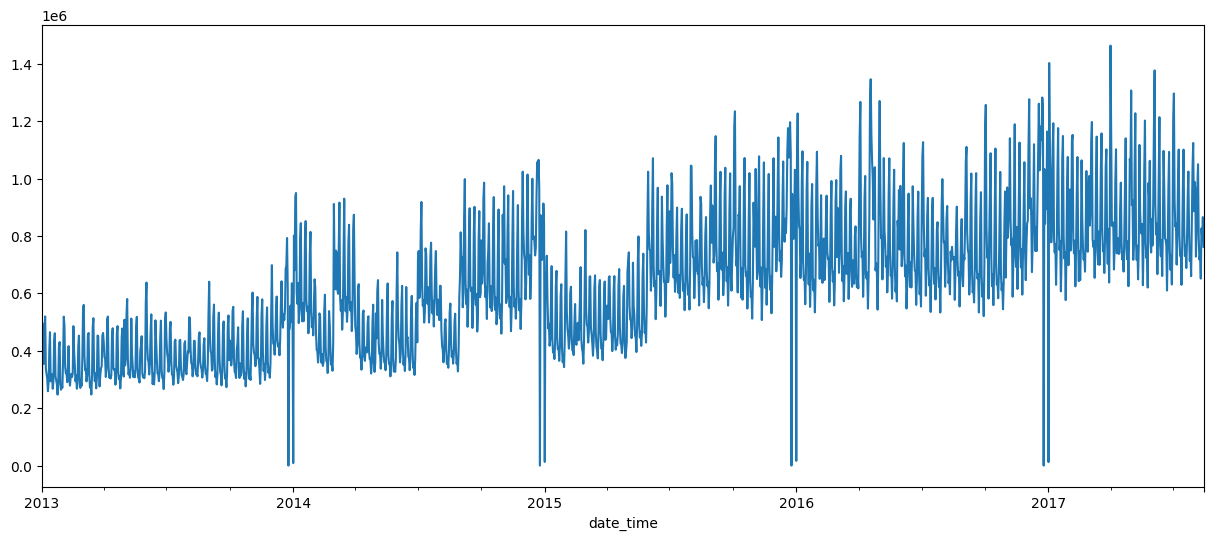

In [18]:
plt.figure(figsize=(15, 6))
sales_total_daily.plot()

##### This daily time series plot of total sales indicates non-stationarity, suggesting differencing or taking logs of the time series or perhaps a Box-cox transformation to stabilise the mean and the varaince, that remains to be discovered in our analysis to follow

In [19]:
min(sales_total_daily.index)

Timestamp('2013-01-01 00:00:00', freq='D')

In [20]:
max(sales_total_daily.index)

Timestamp('2017-08-15 00:00:00', freq='D')

#Earthquake 16 April

In [110]:
earthquake_sales = sales_total_daily[1201:1321]
earthquake_sales

date_time
2016-04-16    8.621215e+05
2016-04-17    1.271834e+06
2016-04-18    1.345921e+06
2016-04-19    1.152089e+06
2016-04-20    1.062426e+06
                  ...     
2016-08-09    6.355390e+05
2016-08-10    6.584574e+05
2016-08-11    5.967293e+05
2016-08-12    7.456625e+05
2016-08-13    7.149059e+05
Freq: D, Name: sales, Length: 120, dtype: float64

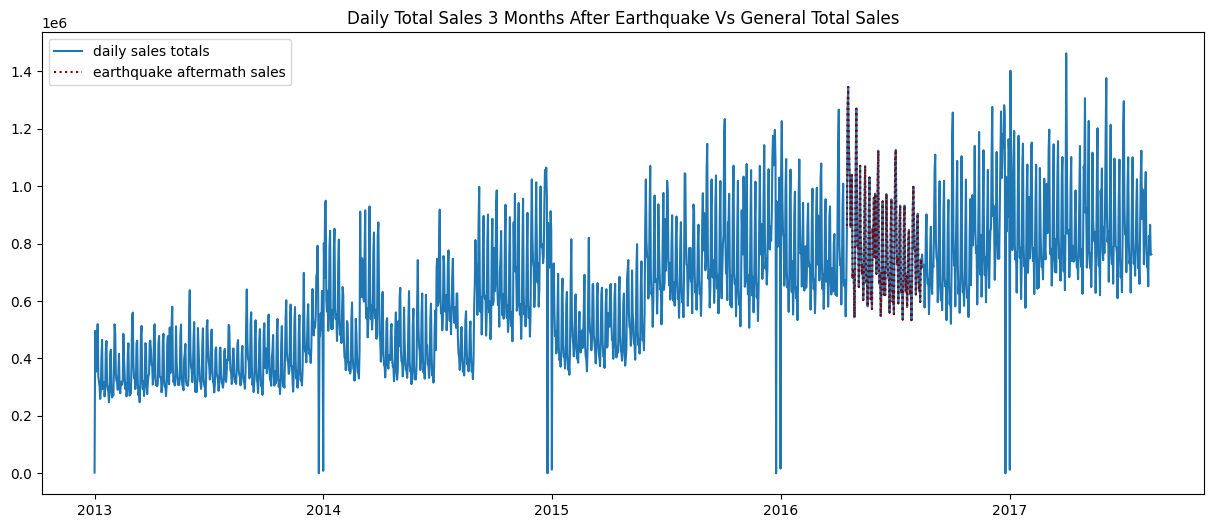

In [121]:
plt.figure(figsize=(15, 6))
plt.title('Daily Total Sales 3 Months After Earthquake Vs General Total Sales')
plt.plot(sales_total_daily, label = 'daily sales totals')
plt.plot(earthquake_sales, label='earthquake aftermath sales', linestyle=':', color = 'maroon')
plt.legend(); plt.show()

From the Figure above, the impact of the earthquake on April 16 does not appear to affect total sales for 4 months to follow, the sales trend appears to continue.

In [21]:
holiday_days=holidays_data['date']

In [22]:
holiday_days[41:]

41     2013-01-01
42     2013-01-05
43     2013-01-12
44     2013-02-11
45     2013-02-12
          ...    
345    2017-12-22
346    2017-12-23
347    2017-12-24
348    2017-12-25
349    2017-12-26
Name: date, Length: 309, dtype: object

In [23]:
holiday_days[-40:-20]

310    2017-05-13
311    2017-05-14
312    2017-05-24
313    2017-05-26
314    2017-06-23
315    2017-06-25
316    2017-06-25
317    2017-06-25
318    2017-07-03
319    2017-07-03
320    2017-07-23
321    2017-07-24
322    2017-07-25
323    2017-08-05
324    2017-08-10
325    2017-08-11
326    2017-08-15
327    2017-08-24
328    2017-09-28
329    2017-09-29
Name: date, dtype: object

# Relevant holidays

In [24]:
rel_holidays = holiday_days[41:326]
rel_holidays

41     2013-01-01
42     2013-01-05
43     2013-01-12
44     2013-02-11
45     2013-02-12
          ...    
321    2017-07-24
322    2017-07-25
323    2017-08-05
324    2017-08-10
325    2017-08-11
Name: date, Length: 285, dtype: object

### finding the total sales during relevant holidays and plotting them

In [25]:
holiday_sales = sales_total_daily.loc[rel_holidays]

In [26]:
holiday_sales

date_time
2013-01-01      2511.618999
2013-01-05    477350.121229
2013-01-12    403258.212011
2013-02-11    278627.588926
2013-02-12    308800.790912
                  ...      
2017-07-24    816564.327096
2017-07-25    713581.632609
2017-08-05    965693.650492
2017-08-10    651386.911970
2017-08-11    826373.722022
Name: sales, Length: 285, dtype: float64

# Time series plot of total daily sales and the total sales per holiday

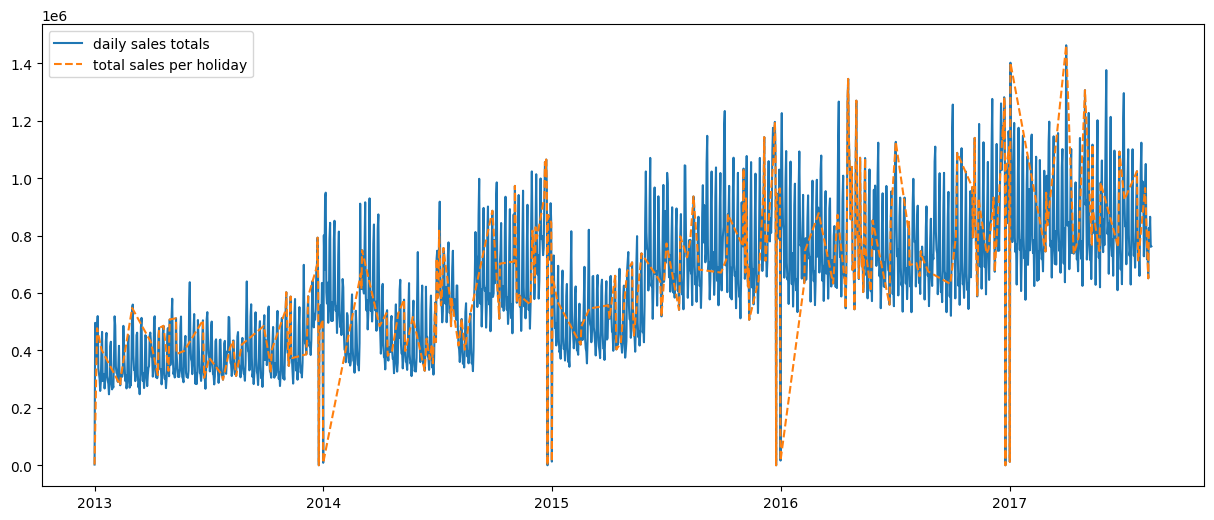

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(sales_total_daily, label = 'daily sales totals')
plt.plot(holiday_sales, label='total sales per holiday', linestyle='--')
plt.legend(); plt.show()

#### According to the above figure it seems as if the holiday sales explain the sharp drops in total sales towards year end, Its interesting to note that during the course of the year the holidays do not seem to have an effect on the daily sales.



In [130]:
sorted_sales_daily_totals = sales_total_daily.sort_values(inplace=False)
sorted_sales_daily_totals.head(10)

date_time
2014-12-25         0.000000
2015-12-25         0.000000
2013-12-25         0.000000
2016-12-25         0.000000
2013-01-01      2511.618999
2014-01-01      8602.065404
2017-01-01     12082.500997
2015-01-01     12773.616980
2016-01-01     16433.394000
2013-01-24    247245.690995
Name: sales, dtype: float64

#### Total sales per holiday data only explains 8 data points in the data which happen to fall on Christmas day and on New Years day, for the rest of the holidays days, sales seem consistent with any other day.

This holiday data set doesnt seem to hold significant predictive power other than expecting less total sales during the Christmas and New Years Eve holidays

Number of overlapping dates after conversion: 449064


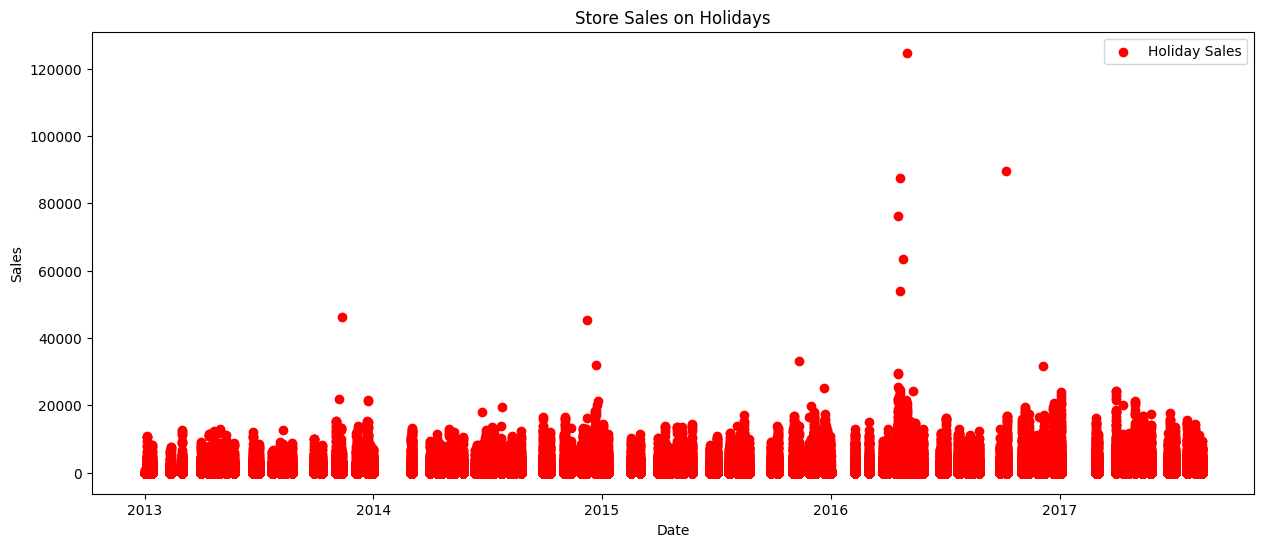

In [28]:
# Ensure 'date' columns are in datetime format
if not pd.api.types.is_datetime64_any_dtype(train_data['date']):
    train_data['date'] = pd.to_datetime(train_data['date'])

if not pd.api.types.is_datetime64_any_dtype(holidays_data['date']):
    holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Remove time components from the dates
train_data['date'] = train_data['date'].dt.date
holidays_data['date'] = holidays_data['date'].dt.date

# Recheck for overlapping dates
overlap_dates = train_data['date'].isin(holidays_data['date']).sum()
print(f"Number of overlapping dates after conversion: {overlap_dates}")

# If there are overlapping dates, proceed with plotting
if overlap_dates > 0:
    # Filter the train data for holiday dates
    holiday_sales = train_data[train_data['date'].isin(holidays_data['date'])]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(holiday_sales['date'], holiday_sales['sales'], color='red', label='Holiday Sales')
    plt.title('Store Sales on Holidays')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
else:
    print("No overlapping holiday dates found in the train dataset even after conversion.")



##Filling missing values in the oil data

# Looking at the oil data

In [29]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


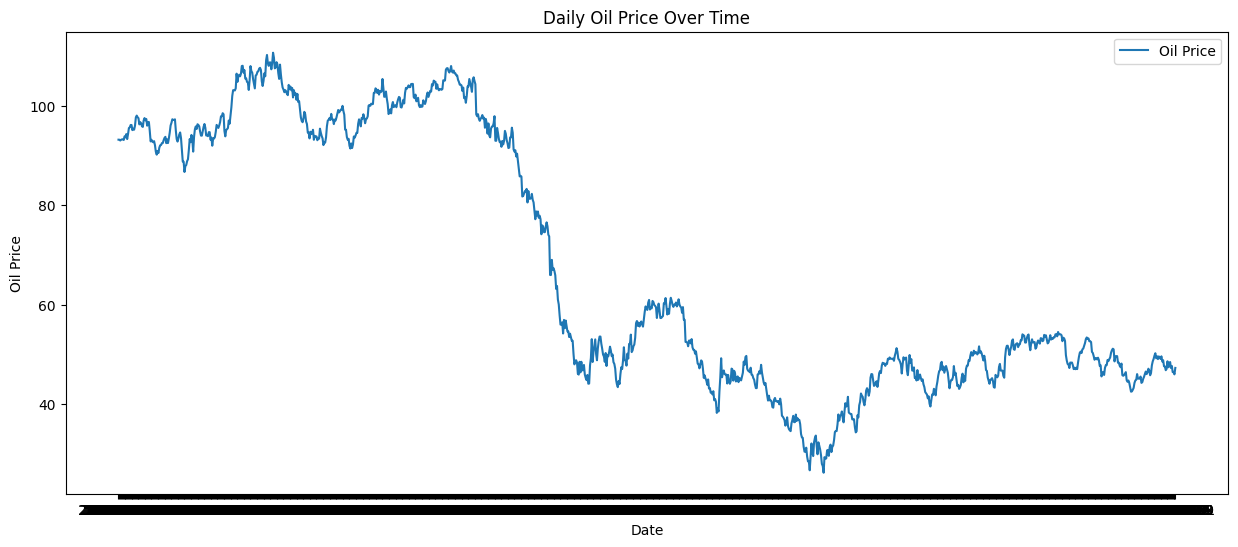

In [131]:
plt.figure(figsize=(15, 6))
plt.plot(oil_data['date'], oil_data['dcoilwtico'], label='Oil Price')
plt.title('Daily Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.legend()
plt.show()

In [31]:
# Check for missing values in the oil dataset
missing_oil_values = oil_data.isnull().sum()

# Display the columns with missing values and their respective counts
print("Missing Oil Values:")
print(missing_oil_values)

# Display specific rows where oil values are missing
missing_oil_rows = oil_data[oil_data['dcoilwtico'].isnull()]
print("\nRows with Missing Oil Values:")
missing_oil_rows.head()

Missing Oil Values:
date           0
dcoilwtico    43
dtype: int64

Rows with Missing Oil Values:


,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN


#### The data has gaps in Filling missing values by using the next observation in the gap

In [32]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [33]:
oil_data=oil_data.backfill()

In [34]:
oil_data

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


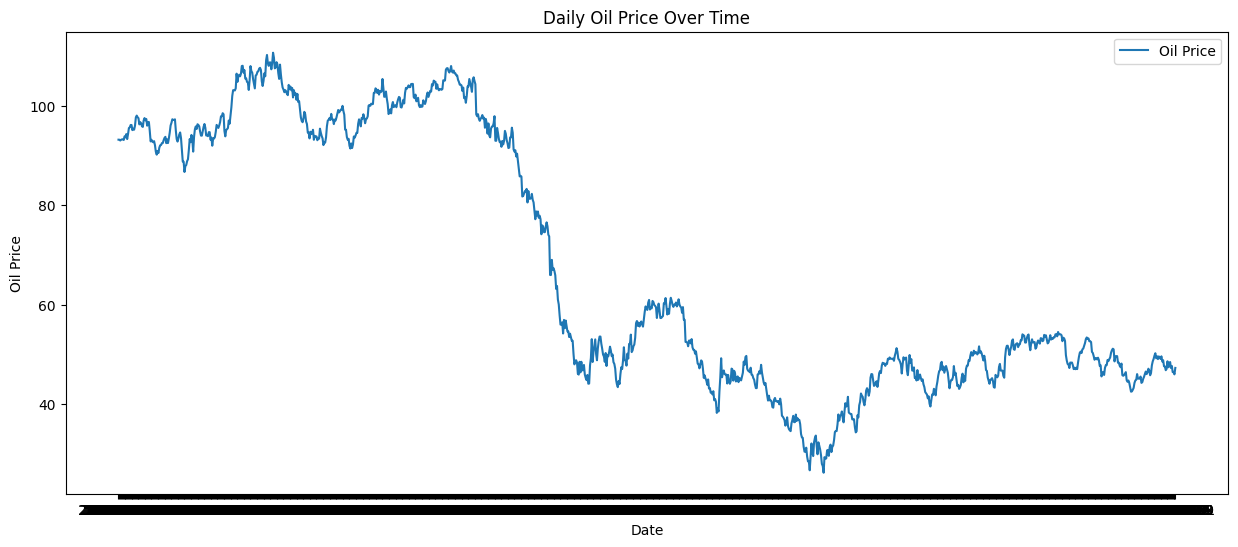

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(oil_data['date'], oil_data['dcoilwtico'], label='Oil Price')
plt.title('Daily Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.legend()
plt.show()

In [36]:
oil_data.shape

(1218, 2)

In [37]:
sales_total_daily.shape

(1688,)

In [38]:
oil_data_ts = oil_data.copy()

In [39]:
oil_data_ts.index = oil_data['date']

In [40]:
oil_data_ts=oil_data_ts.drop(columns='date')
oil_data_ts

,dcoilwtico
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [41]:
sales_total_daily.head(10)

date_time
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
2013-01-06    519695.401088
2013-01-07    336122.801066
2013-01-08    318347.777981
2013-01-09    302530.809018
2013-01-10    258982.003049
Freq: D, Name: sales, dtype: float64

In [42]:
sales_total_daily.tail(2)

date_time
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, dtype: float64

In [43]:
oil_price_days = oil_data_ts.index[:-12]

In [44]:
oil_price_days

Index(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
       '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-14',
       ...
       '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-07', '2017-08-08',
       '2017-08-09', '2017-08-10', '2017-08-11', '2017-08-14', '2017-08-15'],
      dtype='object', name='date', length=1206)

In [45]:
rel_sales_prices = sales_total_daily.loc[oil_price_days]
rel_sales_prices

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-07    336122.801066
                  ...      
2017-08-09    734139.674010
2017-08-10    651386.911970
2017-08-11    826373.722022
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1206, dtype: float64

In [46]:
rel_holidays = holiday_days[41:326]
rel_holidays

41     2013-01-01
42     2013-01-05
43     2013-01-12
44     2013-02-11
45     2013-02-12
          ...    
321    2017-07-24
322    2017-07-25
323    2017-08-05
324    2017-08-10
325    2017-08-11
Name: date, Length: 285, dtype: object

In [47]:
rel_oil_prices=oil_data_ts.loc[oil_price_days]
rel_oil_prices

,dcoilwtico
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-09,49.59
2017-08-10,48.54
2017-08-11,48.81


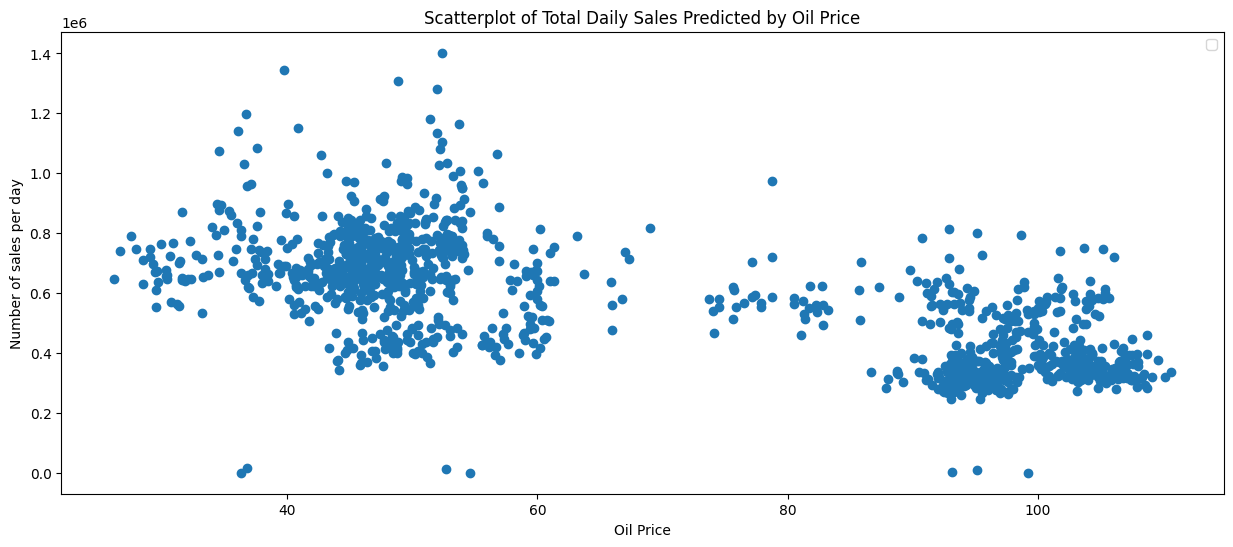

In [132]:
plt.figure(figsize=(15, 6))
plt.scatter(rel_oil_prices['dcoilwtico'] ,rel_sales_prices)
plt.title('Scatterplot of Total Daily Sales Predicted by Oil Price')
plt.xlabel('Oil Price')
plt.ylabel('Number of sales per day')
plt.legend()
plt.show()

#### From the above Scatterplot one can see no clear relationship between oil prices and total sales, there seems to be 10-20% more sales per day when the oil price is between 31 and 60 than when is betweeb 85 and 110

In [49]:
stores_data.shape

(54, 5)

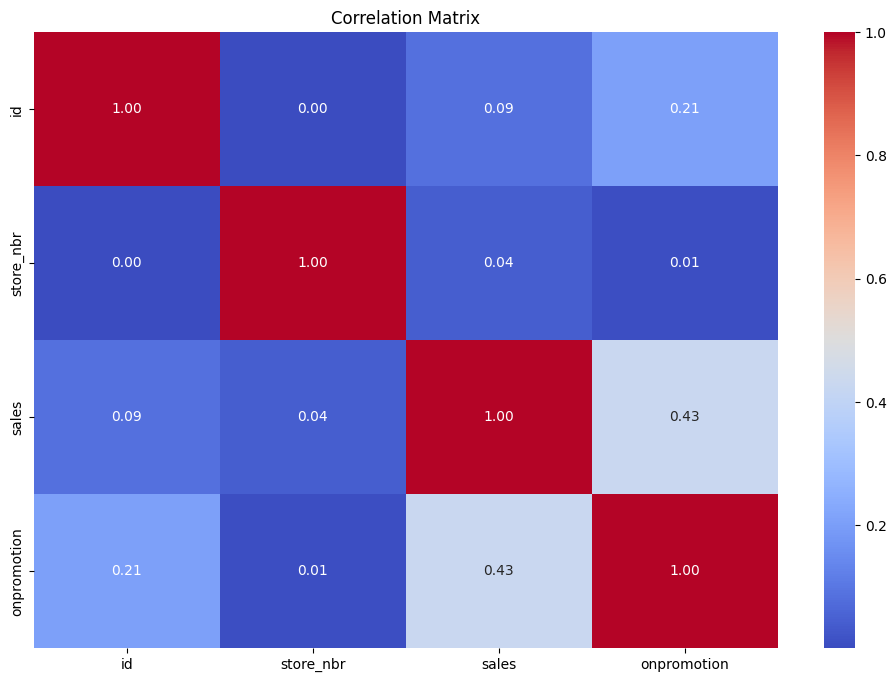

In [50]:
# Assuming combined_data is your DataFrame
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])

# Explore correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [51]:
weekly_sales_data=train_data.resample('W').mean('sales')
weekly_sales_data

,id,store_nbr,sales,onpromotion
date_time,,,,
2013-01-06,5345.5,27.5,206.843478,0.000000
2013-01-13,16928.5,27.5,190.285220,0.000000
2013-01-20,29402.5,27.5,189.835452,0.000000
2013-01-27,41876.5,27.5,182.152050,0.000000
2013-02-03,54350.5,27.5,198.564267,0.000000
...,...,...,...,...
2017-07-23,2953664.5,27.5,460.504663,6.999359
2017-07-30,2966138.5,27.5,474.732392,6.467452
2017-08-06,2978612.5,27.5,513.884368,6.062530


In [52]:
train_data.groupby(['family']).size()

family
AUTOMOTIVE                    90936
BABY CARE                     90936
BEAUTY                        90936
BEVERAGES                     90936
BOOKS                         90936
BREAD/BAKERY                  90936
CELEBRATION                   90936
CLEANING                      90936
DAIRY                         90936
DELI                          90936
EGGS                          90936
FROZEN FOODS                  90936
GROCERY I                     90936
GROCERY II                    90936
HARDWARE                      90936
HOME AND KITCHEN I            90936
HOME AND KITCHEN II           90936
HOME APPLIANCES               90936
HOME CARE                     90936
LADIESWEAR                    90936
LAWN AND GARDEN               90936
LINGERIE                      90936
LIQUOR,WINE,BEER              90936
MAGAZINES                     90936
MEATS                         90936
PERSONAL CARE                 90936
PET SUPPLIES                  90936
PLAYERS AND ELECTRONI

In [53]:
family_feature = train_data.groupby('family')
print(family_feature)


In [54]:
train_data

,id,date,store_nbr,family,sales,onpromotion
date_time,,,,,,
2013-01-01,0,2013-01-01,1,AUTOMOTIVE,0.000,0
2013-01-01,1,2013-01-01,1,BABY CARE,0.000,0
2013-01-01,2,2013-01-01,1,BEAUTY,0.000,0
2013-01-01,3,2013-01-01,1,BEVERAGES,0.000,0
2013-01-01,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
2017-08-15,3000883,2017-08-15,9,POULTRY,438.133,0
2017-08-15,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,2017-08-15,9,PRODUCE,2419.729,148


In [55]:
daily_sales_data.head()

,id,store_nbr,sales,onpromotion
date_time,,,,
2013-01-01,1586871,49005,2511.618999,0
2013-01-02,4762395,49005,496092.417944,0
2013-01-03,7937919,49005,361461.231124,0
2013-01-04,11113443,49005,354459.677093,0
2013-01-05,14288967,49005,477350.121229,0


In [56]:
weekly_sales = weekly_sales_data['sales']
weekly_sales.head()

date_time
2013-01-06    206.843478
2013-01-13    190.285220
2013-01-20    189.835452
2013-01-27    182.152050
2013-02-03    198.564267
Freq: W-SUN, Name: sales, dtype: float64

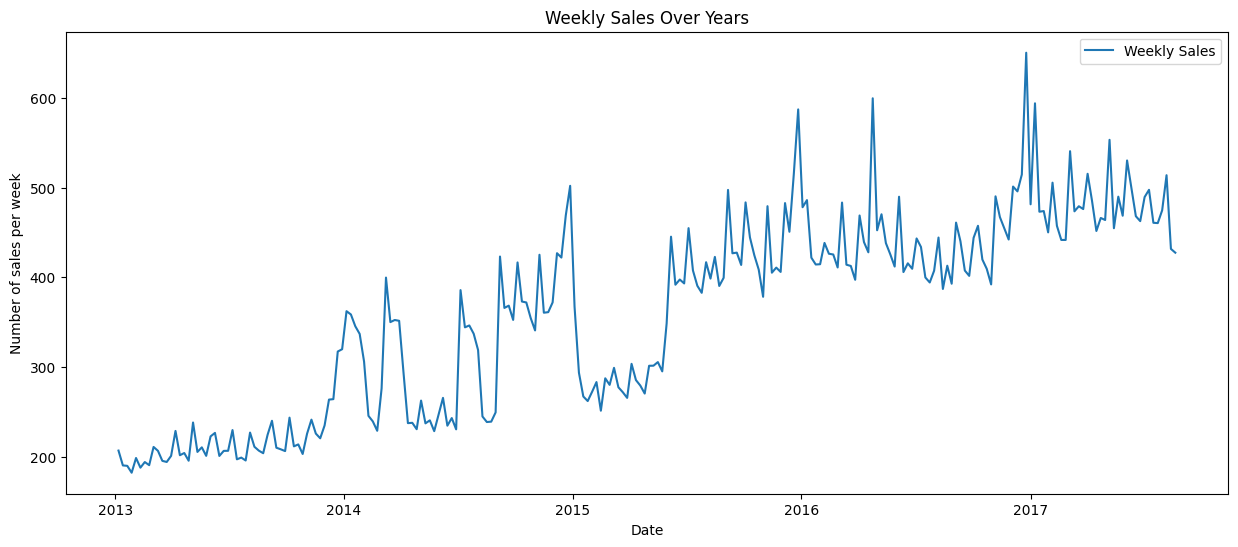

In [133]:
plt.figure(figsize=(15, 6))
plt.plot(weekly_sales, label='Weekly Sales')
plt.title('Weekly Sales Over Years')
plt.xlabel('Date')
plt.ylabel('Number of sales per week')
plt.legend()
plt.show()


###This weekly sales time series plot shows no variance non stationarity. It is increasing, it looks neither mean or variance stationary

#The correlogram and PACF plot

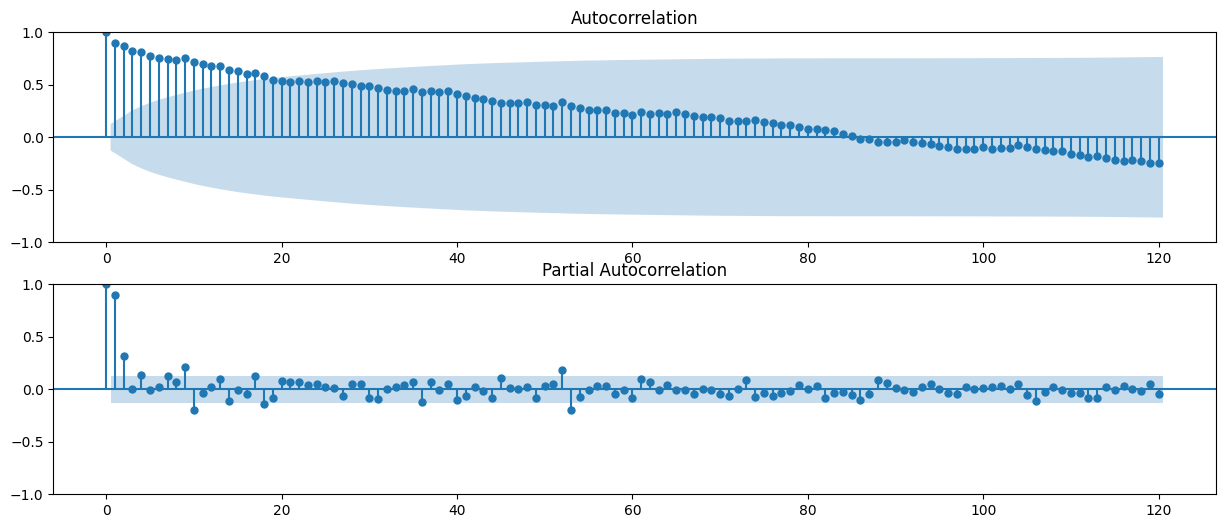

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(15, 6))
plot_acf(weekly_sales, lags=120, ax= fig.add_subplot(211))
plot_pacf(weekly_sales, lags=120, ax= fig.add_subplot(212))
plt.show()

####The Autocorrelation function suggests a high positive autocorrelation from lag 1 to about lag 50. The points between different time steps seems related to the one another quite strongly between these lags.

For random data ('white noise') autocorrelation should be close to zero for all lags. this also suggests a trend. When seasonal patterns are present, the autocorrelations are larger for lags at multiples of the seasonal frequency than for other lags, we can see them spiking

####The PACF  suggests fitting either a first or second-order autoregressive model.

#Seasonality

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 1500x600 with 0 Axes>

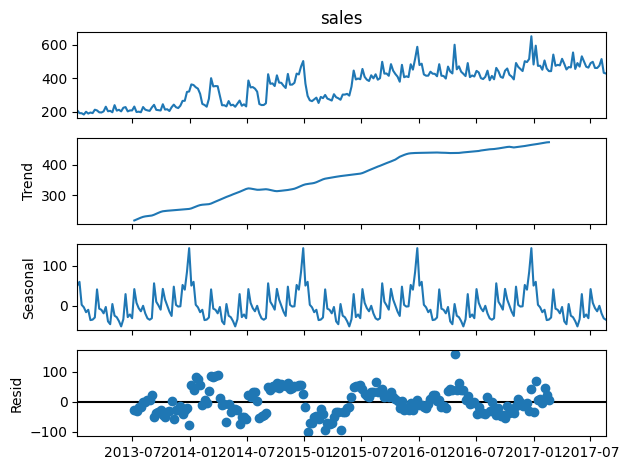

In [135]:
fig = plt.figure(figsize=(15, 6))
add_weekly_sales_decompose = seasonal_decompose(weekly_sales, model='additive',period=52)
add_weekly_sales_decompose.plot()
plt.show()

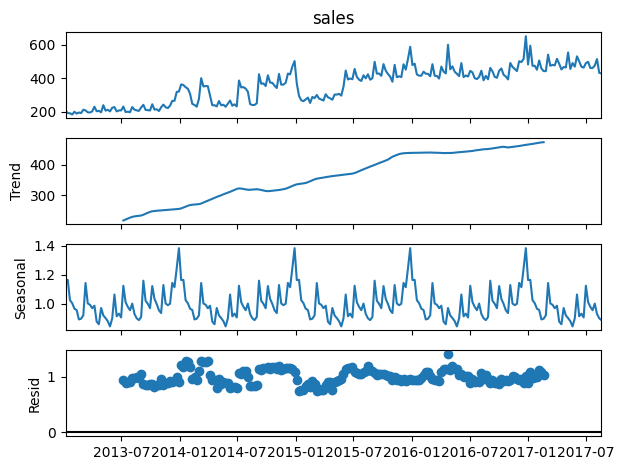

In [61]:
mul_weekly_sales_decompose = seasonal_decompose(weekly_sales, model='multiplicative',period=52)
mul_weekly_sales_decompose.plot()
plt.show()

####There is clear a seasonality trend underlying in time series, the additive model seems to bew the better model, the residuals are centered around zero, suggesting that relationship is linear, errors are normally distributed , errors hava an equal variance around the line zero and Independence of the observations, thus regression model assumptions are met after removing seasonality.

This is a great indicator

#Testing for Stationarity

The null hypothesis for the test is that the data is stationary.
The alternate hypothesis for the test is that the data is not stationary.

The p-value is less than than alpha levels, hence we reject the null hypothesis that the data is stationary.

In [62]:
from statsmodels.tsa.stattools import kpss
kpss(weekly_sales,regression='c', nlags='auto')

<ipython-input-62-b9ba7f7d372a>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(weekly_sales,regression='c', nlags='auto')


(2.2379597393237645,
 0.01,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The P-value is less than all the alpha values at all significance levels so we reject the null hypothesis: H0 that the time series is stationery as seen above.

##Differencing

In [63]:
weekly_sales_diff = weekly_sales.diff(1)
weekly_sales_diff

date_time
2013-01-06          NaN
2013-01-13   -16.558258
2013-01-20    -0.449768
2013-01-27    -7.683402
2013-02-03    16.412218
                ...    
2017-07-23    -0.335118
2017-07-30    14.227729
2017-08-06    39.151976
2017-08-13   -82.154223
2017-08-20    -4.237345
Freq: W-SUN, Name: sales, Length: 242, dtype: float64

In [64]:
weekly_sales_diff = weekly_sales_diff .dropna()

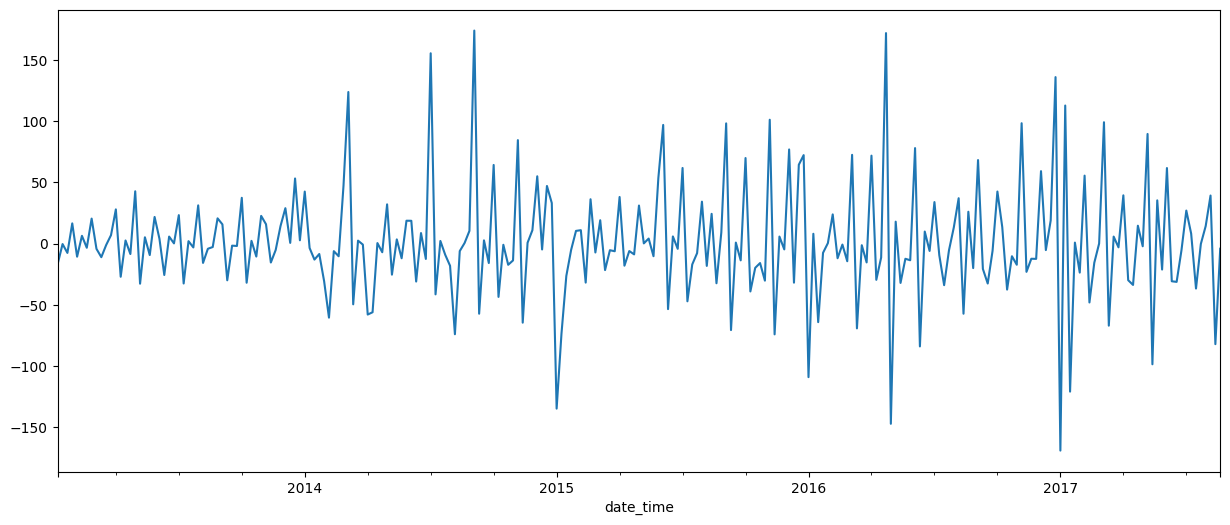

In [65]:
fig = plt.figure(figsize=(15, 6))
weekly_sales_diff.plot(); plt.show()

###This differenced time series looks mean and variance stationary by inspection

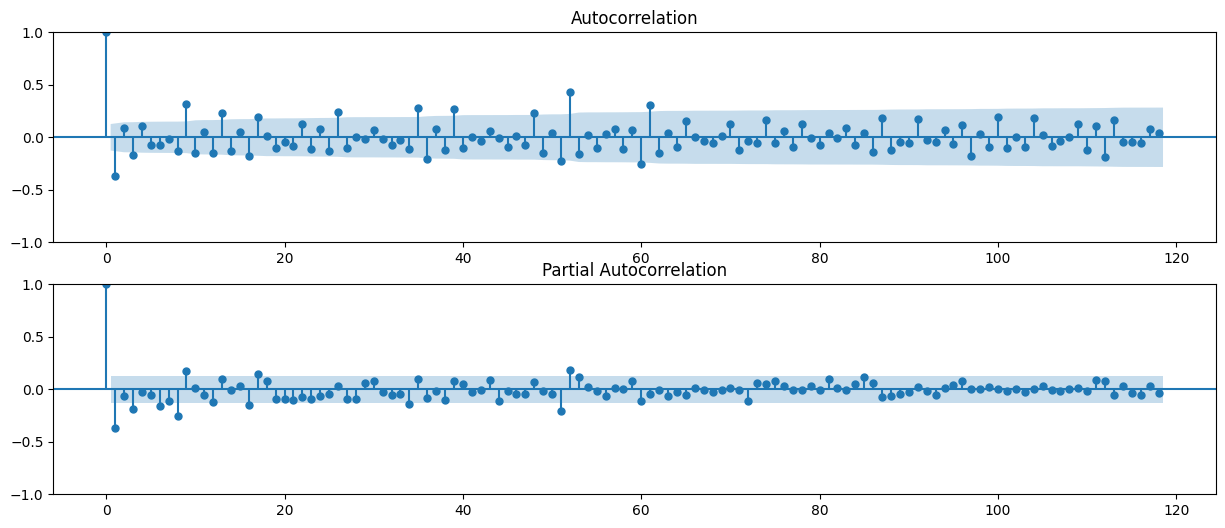

In [66]:
fig = plt.figure(figsize=(15, 6))
plot_acf(weekly_sales_diff, lags=118, ax= fig.add_subplot(211))
plot_pacf(weekly_sales_diff, lags=118, ax= fig.add_subplot(212))
plt.show()

As expected the Autocorrelation function suggests a low autocorrelation
however there seems to be a slight presence of seasonal patterns, uncertain if they are statistically significant, the autocorrelations still seem larger for lags at multiples of the seasonal frequency than for other lags.


###KPSS Test


In [67]:
kpss(weekly_sales_diff, regression ='c', nlags='auto')

<ipython-input-67-ec3627e01e7b>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(weekly_sales_diff, regression ='c', nlags='auto')


(0.1516523269381824,
 0.1,
 45,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

###This time the p-value is greater than all alpha levels suggesting we reject the alternative hypothesis that the time series is non stationary

##Build Model


In [68]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [69]:
test_data['date'] = pd.to_datetime(test_data['date'])

In [70]:
test_data.index = test_data['date']
test_data.drop(columns='date')
test_data.head()

,id,date,store_nbr,family,onpromotion
date,,,,,
2017-08-16,3000888,2017-08-16,1,AUTOMOTIVE,0
2017-08-16,3000889,2017-08-16,1,BABY CARE,0
2017-08-16,3000890,2017-08-16,1,BEAUTY,2
2017-08-16,3000891,2017-08-16,1,BEVERAGES,20
2017-08-16,3000892,2017-08-16,1,BOOKS,0


In [71]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
date_time,,,,,,
2013-01-01,0,2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,2013-01-01,1,BABY CARE,0.0,0
2013-01-01,2,2013-01-01,1,BEAUTY,0.0,0
2013-01-01,3,2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,4,2013-01-01,1,BOOKS,0.0,0


###Sales is our target variable "y"

In [72]:
weekly_sales_data.head()

,id,store_nbr,sales,onpromotion
date_time,,,,
2013-01-06,5345.5,27.5,206.843478,0.0
2013-01-13,16928.5,27.5,190.285220,0.0
2013-01-20,29402.5,27.5,189.835452,0.0
2013-01-27,41876.5,27.5,182.152050,0.0
2013-02-03,54350.5,27.5,198.564267,0.0


In [73]:
weekly_sales_diff.head()

date_time
2013-01-13   -16.558258
2013-01-20    -0.449768
2013-01-27    -7.683402
2013-02-03    16.412218
2013-02-10   -10.776095
Freq: W-SUN, Name: sales, dtype: float64

In [74]:
weekly_sales_data = pd.merge(weekly_sales_data, weekly_sales_diff, right_index = True,
               left_index = True)
weekly_sales_data

,id,store_nbr,sales_x,onpromotion,sales_y
date_time,,,,,
2013-01-13,16928.5,27.5,190.285220,0.000000,-16.558258
2013-01-20,29402.5,27.5,189.835452,0.000000,-0.449768
2013-01-27,41876.5,27.5,182.152050,0.000000,-7.683402
2013-02-03,54350.5,27.5,198.564267,0.000000,16.412218
2013-02-10,66824.5,27.5,187.788172,0.000000,-10.776095
...,...,...,...,...,...
2017-07-23,2953664.5,27.5,460.504663,6.999359,-0.335118
2017-07-30,2966138.5,27.5,474.732392,6.467452,14.227729
2017-08-06,2978612.5,27.5,513.884368,6.062530,39.151976


In [75]:
weekly_sales_data['sales_y']

date_time
2013-01-13   -16.558258
2013-01-20    -0.449768
2013-01-27    -7.683402
2013-02-03    16.412218
2013-02-10   -10.776095
                ...    
2017-07-23    -0.335118
2017-07-30    14.227729
2017-08-06    39.151976
2017-08-13   -82.154223
2017-08-20    -4.237345
Freq: W-SUN, Name: sales_y, Length: 241, dtype: float64

In [76]:
ws_diff_df = pd.DataFrame(weekly_sales_data['sales_y'])
ws_diff_df

,sales_y
date_time,
2013-01-13,-16.558258
2013-01-20,-0.449768
2013-01-27,-7.683402
2013-02-03,16.412218
2013-02-10,-10.776095
...,...
2017-07-23,-0.335118
2017-07-30,14.227729
2017-08-06,39.151976


In [77]:
scaler = MinMaxScaler()

In [78]:
print(scaler.fit(ws_diff_df))

MinMaxScaler()


In [79]:
ws_diff_df = scaler.transform(ws_diff_df)

In [80]:
ws_diff_df.shape

(241, 1)

In [81]:
ws_diff_frame = pd.DataFrame(ws_diff_df, columns = ['scaled_sales'])
ws_diff_frame

,scaled_sales
0,0.444743
1,0.491734
2,0.470632
3,0.540924
4,0.461610
...,...
236,0.492069
237,0.534551
238,0.607259
239,0.253388


In [82]:
ws_diff_frame.index = weekly_sales_data.index
ws_diff_frame

,scaled_sales
date_time,
2013-01-13,0.444743
2013-01-20,0.491734
2013-01-27,0.470632
2013-02-03,0.540924
2013-02-10,0.461610
...,...
2017-07-23,0.492069
2017-07-30,0.534551
2017-08-06,0.607259


In [83]:
#s_diff_frame = ws_diff_frame.rename(columns = {'[0]':'scaled_sales'},inplace=True, errors='raise')
#ws_diff_frame
#df.rename(columns={'oldName1': 'newName1','oldName2': 'newName2'},inplace=True, errors='raise')

In [84]:
weekly_sales_data = pd.merge(weekly_sales_data, ws_diff_frame, right_index = True,
               left_index = True)
weekly_sales_data.head()

,id,store_nbr,sales_x,onpromotion,sales_y,scaled_sales
date_time,,,,,,
2013-01-13,16928.5,27.5,190.285220,0.0,-16.558258,0.444743
2013-01-20,29402.5,27.5,189.835452,0.0,-0.449768,0.491734
2013-01-27,41876.5,27.5,182.152050,0.0,-7.683402,0.470632
2013-02-03,54350.5,27.5,198.564267,0.0,16.412218,0.540924
2013-02-10,66824.5,27.5,187.788172,0.0,-10.776095,0.461610


In [85]:
weekly_sales_data = weekly_sales_data.drop(columns=['sales_x', 'sales_y'])
weekly_sales_data

,id,store_nbr,onpromotion,scaled_sales
date_time,,,,
2013-01-13,16928.5,27.5,0.000000,0.444743
2013-01-20,29402.5,27.5,0.000000,0.491734
2013-01-27,41876.5,27.5,0.000000,0.470632
2013-02-03,54350.5,27.5,0.000000,0.540924
2013-02-10,66824.5,27.5,0.000000,0.461610
...,...,...,...,...
2017-07-23,2953664.5,27.5,6.999359,0.492069
2017-07-30,2966138.5,27.5,6.467452,0.534551
2017-08-06,2978612.5,27.5,6.062530,0.607259


In [86]:
weekly_sales_data .columns

Index(['id', 'store_nbr', 'onpromotion', 'scaled_sales'], dtype='object')

In [87]:
weekly_sales_data

,id,store_nbr,onpromotion,scaled_sales
date_time,,,,
2013-01-13,16928.5,27.5,0.000000,0.444743
2013-01-20,29402.5,27.5,0.000000,0.491734
2013-01-27,41876.5,27.5,0.000000,0.470632
2013-02-03,54350.5,27.5,0.000000,0.540924
2013-02-10,66824.5,27.5,0.000000,0.461610
...,...,...,...,...
2017-07-23,2953664.5,27.5,6.999359,0.492069
2017-07-30,2966138.5,27.5,6.467452,0.534551
2017-08-06,2978612.5,27.5,6.062530,0.607259


In [88]:
weekly_sales_test_data=test_data.resample('W').mean('sales')
weekly_sales_test_data

,id,store_nbr,onpromotion
date,,,
2017-08-20,3005342.5,27.5,7.850505
2017-08-27,3016034.5,27.5,6.133718
2017-09-03,3025835.5,27.5,7.314394


Calculating the baseline Root Mean Squared Logarithmic Error

In [89]:
y_train = weekly_sales_data['scaled_sales']

In [90]:
y_test = weekly_sales_test_data

In [91]:
y_train_mean = y_train.mean()
y_train_mean


0.4957169789026688

In [92]:
y_prediction_baseline = [y_train_mean]*len(y_train)

In [93]:
rmsle_baseline = mean_squared_log_error(y_train,y_prediction_baseline,squared=False)
rmsle_baseline
print(" Root Mean Square Log Error Baseline :", round(rmsle_baseline, 2))

 Root Mean Square Log Error Baseline : 0.09


In [94]:
!pip install pmdarima

In [95]:
from pmdarima.arima import auto_arima

In [138]:
model = auto_arima(y_train, start_p=1, start_q=1 ,test='adf',max_p=5, max_q=5, m=1,
                      d=1,
                      seasonal=False,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29.610, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-169.943, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.610, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-195.451, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-228.958, Time=0.34 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-242.552, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-243.832, Time=0.40 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-294.400, Time=0.70 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-293.740, Time=0.44 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0] intercept
Total fit tim

According to the algorithm the best ARIMA model is ARIMA (5,1,1)

In [97]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  241
Model:               SARIMAX(5, 1, 1)   Log Likelihood                 155.200
Date:                Fri, 24 Nov 2023   AIC                           -294.400
Time:                        15:38:30   BIC                           -266.555
Sample:                    01-13-2013   HQIC                          -283.180
                         - 08-20-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.218e-05      0.000     -0.105      0.916      -0.001       0.001
ar.L1         -0.4838      0.061     -7.908      0.000      -0.604      -0.364
ar.L2         -0.1837      0.089     -2.061      0.039      -0.358      -0.009
ar.L3         -0.2374      0.093     -2.557      0.011      -0.419      -0.055
ar.L4         -0.0807      0.083     -0.976      0.329      -0.243       0.081
ar.L5         -0.1066      0.078     -1.370      0.171      -0.259       0.046
ma.L1         -0.9797      0.053    -18.328      0.000      -1.084      -0.875
sigma2         0.0168      0.002     10.587      0.000       0.014       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):               123.94
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#The Ljung box test

#####H0: The data are independently distributed
#####Ha: The data are not independently distributed; they exhibit serial correlation.

###### The model summary shows there is no correlation  in the residuals (independent errors) the p value of the Ljung-Box test for White noise (randomness) is greater than 0.4 which is greater than alpha values, so we reject the alternative hypothesis that the data has serial correlation.

The residual distribution doesnt seem to show constant variance since the p-value of the Heteroskedasticity test is smaller than 0.05.

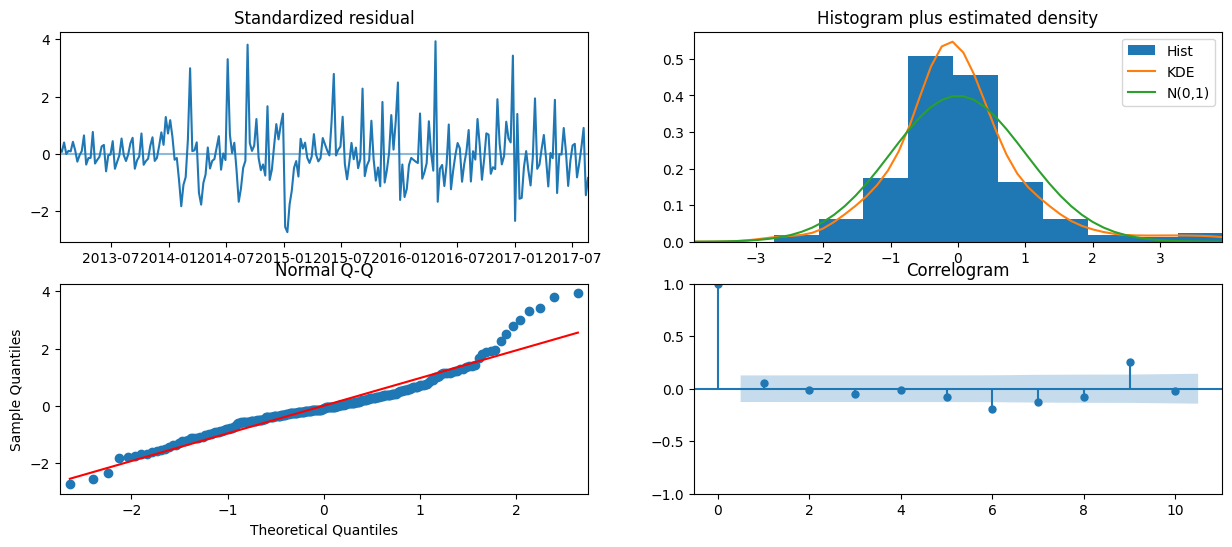

In [98]:
model.plot_diagnostics(figsize=(15, 6))
plt.show()

#Forecast

In [99]:
#y_tes

In [100]:
# Forecast

prediction, confint = model.predict(n_periods=3, return_conf_int=True)

prediction

2017-08-27    0.510726
2017-09-03    0.528026
2017-09-10    0.480938
Freq: W-SUN, dtype: float64

In [101]:
cf= pd.DataFrame(confint)

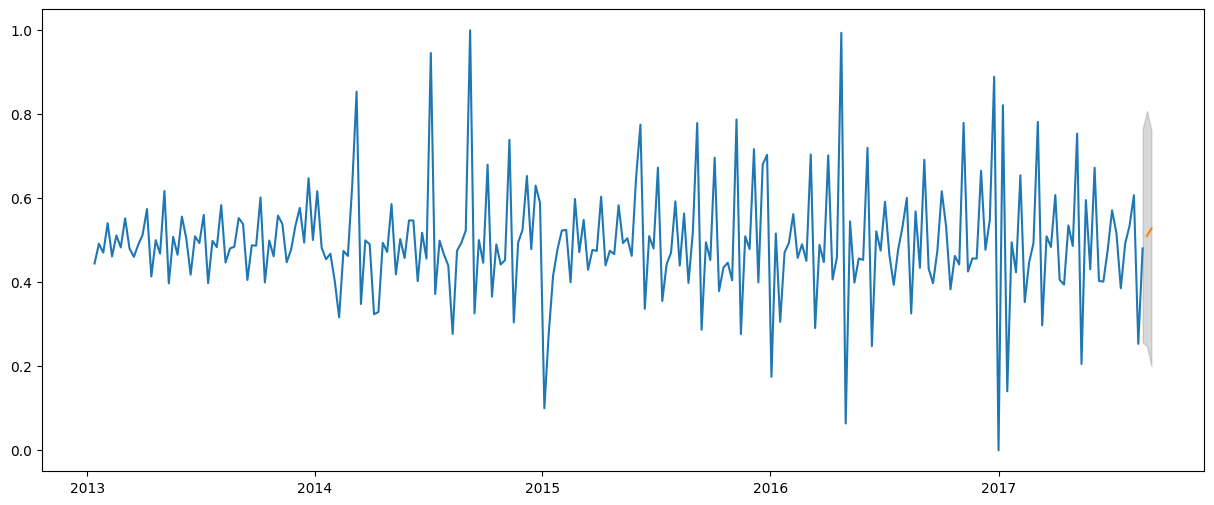

In [102]:
forecast = pd.Series(prediction,index=y_test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(weekly_sales_data['scaled_sales'])
ax.plot(forecast)
ax.fill_between(forecast.index,
                cf[0],
                cf[1],color='grey',alpha=.3)